In [ ]:
#imports
import numpy as np
from PIL import Image
import os
import glob
import tensorflow as tf
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import re
import pandas
from PIL import Image
from tensorflow import keras
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.preprocessing import StandardScaler
import csv
from tensorflow.keras.layers import Input 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from PIL.Image import fromarray
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import seaborn as sns





In [4]:
# retrieve y_train values from csv
# retrieve the x_train file names
files_ids = []
y_trainn =[]

prefix = r"C:/Users/FYP/Documents/eyedata/"
with open('{}trainLabels.csv'.format(prefix)) as file:
    reader = list(csv.reader(file, delimiter=','))
    for row in reader:
        files_ids.append(r"C:/Users/FYP/Documents/eyedata/400x400/train/" + row[0] + ".jpeg")
        y_trainn.append(row[1])
files_ids = files_ids[1:]
y_trainn = [int(i) for i in y_trainn[1:]]

In [5]:
# retrieve all x_train images and append into array
x_train = []

x_train_ids = []
def get_x_train_shrinked():
    for x in files_ids:
        x_train_ids.append(r"C:/Users/FYP/Documents/eyedata/400x400/train/" + os.path.basename(x))
        image = Image.open(x)
        x_train.append(np.asarray(image, dtype=np.uint8))


In [6]:
get_x_train_shrinked()

In [7]:
# x_train into numpy array
x_train = np.array(x_train)


In [8]:
# sort the y_train values corresponding to the x_train file name
y_train = []
for i in x_train_ids:
    for j in range(len(files_ids)):
        if i == files_ids[j]:
            y_train.append(y_trainn[j])

y_train = np.array(y_train)

Counter({0: 25808, 2: 5292, 1: 2443, 3: 873, 4: 708})


Text(0, 0.5, 'Class')

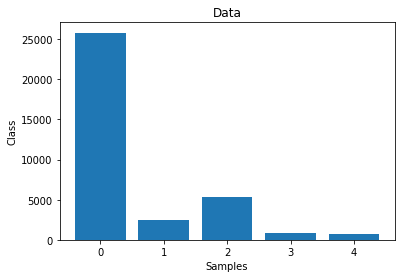

In [9]:
print(Counter(y_train))
w = Counter(y_train)
plt.bar(w.keys(), w.values())
plt.title('Data')
plt.xlabel('Samples')
plt.ylabel('Class')

In [10]:
# x_train_test split at 30% with stratify
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, stratify=y_train)


In [11]:
# Undersampling
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE


oversample = SMOTE()


undersample = RandomUnderSampler(sampling_strategy={0:5000},random_state=42)
size = len(X_train)
X_train = X_train.reshape(size, -1)
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_train = X_train.reshape(-1,300,300,3)

In [40]:
# class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
manual_weights = dict(enumerate(class_weights))

In [12]:
totalMaj = sorted(Counter(y_train).items())[0][1]
totalMin = sorted(Counter(y_train).items())[1][1] + sorted(Counter(y_train).items())[2][1] + sorted(Counter(y_train).items())[3][1] + sorted(Counter(y_train).items())[4][1]

print('Record in training dataset:', X_train.shape[0])
print('Record in testing dataset:', X_val.shape[0])
print(f"Training dataset has {totalMaj} records for the majority class and {totalMin} records for the minority class.")

Record in training dataset: 25000
Record in testing dataset: 7025
Training dataset has 5000 records for the majority class and 20000 records for the minority class.


In [16]:
#python image generator
train_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)



In [17]:
# Train generator for only training
train_generator = validation_datagen.flow_from_directory(
    directory="C:/Users/FYP/Documents/eyedata/dataflow/train/",
    target_size=(300,300),
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=42
)
# Validation generator for validation data
validation_generator = validation_datagen.flow_from_directory(
    directory="C:/Users/FYP/Documents/eyedata/dataflow/validation/",
    target_size=(300,300),
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    seed=42)
# Prediction data for the x_validation data
validation2_generator = validation_datagen.flow_from_directory(
    directory="C:/Users/FYP/Documents/eyedata/dataflow/validation/",
    target_size=(300,300),
    batch_size=1,
    class_mode=None,
    shuffle=False)

Found 25000 images belonging to 5 classes.
Found 7025 images belonging to 5 classes.
Found 53576 images belonging to 1 classes.
Found 7025 images belonging to 5 classes.


In [ ]:
# build the xception CNN model with 300x300 image size
input_shape=(300, 300, 3)

img_input = Input(shape=input_shape)
base_model = tf.keras.applications.Xception(include_top=False, input_tensor=img_input, input_shape=input_shape, pooling="max", weights='imagenet')

#train on all the layers of the pre-trained model
base_model.trainable = True
x = base_model.output
predictions = Dense(5, activation="softmax", name="predictions")(x)
model = Model(inputs=img_input, outputs=predictions)

# compile model
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

# save model at every iteration where the accuracy increases
checkpoint = ModelCheckpoint(filepath='bestmodel.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1)



history = model.fit_generator(generator=train_generator, validation_data=validation_generator,
          epochs=15,
          callbacks=[checkpoint]
        #   class_weight=manual_weights
        )

In [ ]:
#print graphs for the accuracy and loss of model
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# validate model on the validation set
STEP_SIZE_TEST=validation2_generator.n//validation2_generator.batch_size
validation2_generator.reset()
pred=model.predict_generator(validation2_generator,
steps=STEP_SIZE_TEST,
verbose=1)

In [28]:
# predicted values of all images on the validation set
predicted_x_val=np.argmax(pred,axis=1)


Counter({0: 4868, 2: 1553, 1: 307, 4: 191, 3: 106})

In [ ]:
# display the accuracy and the confusion matrix
print("Accuracy on testing data: %2.2f%% " % (accuracy_score(y_val,predicted_x_val)))
print(classification_report(y_val,predicted_x_val))

In [ ]:
import seaborn as sns

confusion = sns.heatmap(confusion_matrix(y_val,predicted_x_val), annot=True, fmt='d', cbar=False, cmap=plt.cm.Blues)
confusion.set_xlabel("Actual Label", fontsize = 10)
confusion.set_ylabel("Predicted Label", fontsize = 10)

In [ ]:
# retreive the cohen's kappa score
cohen_kappa_score(predicted_x_val, y_val)